# Functions

In [47]:
import itertools
import scipy.linalg as linalg
import scipy.stats as stats
max_iterations = 100000
target = "log_y"
forecast_horizon = 45
def impute_series(pd_df,target=target,window=7,min_periods=1,center=True):
    return(pd_df.fillna(pd_df.rolling(window=7,min_periods=1,center=True).mean())[target])
def ssa(y, dim):
    """
    Singular Spectrum Analysis decomposition for a time series
    Example:
    -------
    >>> import numpy as np
    >>>
    >>> x = np.linspace(0, 5, 1000)
    >>> y = 2*x + 2*np.sin(5*x) + 0.5*np.random.randn(1000)
    >>> pc, s, v = ssa(y, 15)
    :param y: time series (array)
    :param dim: the embedding dimension
    :return: (pc, s, v) where
             pc is the matrix with the principal components of y
             s is the vector of the singular values of y given dim
             v is the matrix of the singular vectors of y given dim
    """
    n = len(y)
    t = n - (dim - 1)

    yy = linalg.hankel(y, np.zeros(dim))
    yy = yy[:-dim + 1, :] / np.sqrt(t)

    # here we use gesvd driver (as in Matlab)
    _, s, v = linalg.svd(yy, full_matrices=False, lapack_driver='gesvd')

    # find principal components
    vt = np.matrix(v).T
    pc = np.matrix(yy) * vt

    return np.asarray(pc), s, np.asarray(vt)

def inv_ssa(pc, v, k):
    """
    Series reconstruction for given SSA decomposition using vector of components
    Example:
    -------
    >>> import numpy as np
    >>> from matplotlib import pyplot as plt
    >>> x = np.linspace(0, 5, 1000)
    >>> y = 2*x + 2*np.sin(5*x) + 0.5*np.random.randn(1000)
    >>> pc, s, v = ssa(y, 15)
    >>>
    >>> yr = inv_ssa(pc, v, [0,1])
    >>> plt.plot(x, yr)
    :param pc: matrix with the principal components from SSA
    :param v: matrix of the singular vectors from SSA
    :param k: vector with the indices of the components to be reconstructed
    :return: the reconstructed time series
    """
    if isscalar(k): k = [k]

    if pc.ndim != 2:
        raise ValueError('pc must be a 2-dimensional matrix')

    if v.ndim != 2:
        raise ValueError('v must be a 2-dimensional matrix')

    t, dim = pc.shape
    n_points = t + (dim - 1)

    if any(filter(lambda x: dim < x or x < 0, k)):
        raise ValueError('k must be vector of indexes from range 0..%d' % dim)

    pc_comp = np.asarray(np.matrix(pc[:, k]) * np.matrix(v[:, k]).T)

    xr = np.zeros(n_points)
    times = np.zeros(n_points)

    # reconstruction loop
    for i in range(dim):
        xr[i : t + i] = xr[i : t + i] + pc_comp[:, i]
        times[i : t + i] = times[i : t + i] + 1

    xr = (xr / times) * np.sqrt(t)
    return xr

def ssa_cutoff_order(x, dim=200, cutoff_pctl=75, show_plot=False):
    """
    Tries to find best cutoff for number of order when increment changes of informational entropy
    becomes little and the effective information saturates.
    :param x: series
    :param dim: embedding dimensions (200 by default)
    :param cutoff_pctl: percentile of changes (75%)
    :param show_plot: true if we need to see informational curve
    :return: cutoff number
    """
    _, s, _ = ssa(x, dim)
    curve = -s/s.sum() * np.log(s/s.sum())
    pctl = np.percentile(curve, cutoff_pctl)
    n_cutoff = sum(curve > pctl)
        
    return n_cutoff

def ssa_predict(x, dim, k, n_forecast, e=None, max_iter=max_iterations):
    """
    Series data prediction based on SSA
    Example:
    >>> x = np.linspace(0,5,1000)
    >>> y = 2*x + 2*np.sin(5*x) + 0.5*np.random.randn(1000)
    >>>
    >>> # make prediction for next 200 points
    >>> ys = ssa_predict(y, 100, [0,1,2], 200, 0.01)
    >>> 
    >>> # plot prediction
    >>> plt.figure(figsize=(16,8));
    >>> x0 = len(y); plt.plot(range(x0), y); plt.plot(range(x0, x0 + len(ys)), ys, 'r--')
    >>> plt.legend(['Data', 'Forecast'])
    :param x: series to be predicted
    :param dim: the embedding dimension
    :param k: components indexes for reconstruction
    :param n_forecast: number of points to forecast
    :param e: minimum value to ensure convergence
    :param max_iter: maximum number of iterations
    :return: forecasted series
    """
    if not e:
        e = 0.0001 * (np.max(x) - np.min(x))
    mean_x = x.mean()
    x = x - mean_x
    xf = nans(n_forecast)

    for i in range(n_forecast):
        # here we use previous value as initial estimation
        x = np.append(x, x[-1])
        yq = x[-1]
        y = yq + 2 * e
        n_iter = max_iter
        
        while abs(y - yq) > e:
            yq = x[-1]

            pc, _, v = ssa(x, dim)
            xr = inv_ssa(pc, v, k)

            y = xr[-1]
            x[-1] = y
            n_iter -= 1
            if n_iter <= 0:
                print('ssa_predict> number of iterations exceeded')
                break

        xf[i] = x[-1]
    xf = xf + mean_x
    return xf

def isscalar(x):
  """
  Returns true if x is scalar value
  :param x:
  :return:
  """
  return not isinstance(x, (list, tuple, dict, np.ndarray))

def mape(f, t):
    return 100*((f - t)/t).abs().sum()/len(t)

def mae(f, t):
    return 100*((f - t)).abs().sum()/len(t)
  
def nans(dims):
    """
    nans((M,N,P,...)) is an M-by-N-by-P-by-... array of NaNs.
    :param dims: dimensions tuple
    :return: nans matrix
    """
    return np.nan * np.ones(dims)  

def ssa_denoise(pd_df,target,n_component=list(range(20))):
    pd_df['imputed_'+target] = impute_series(pd_df)
    arrayData = np.array(pd_df['imputed_'+target])
    dim = len(arrayData)//2
    k = ssa_cutoff_order(arrayData,dim = dim)
    pc, s, v = ssa(arrayData,dim)
    yr = inv_ssa(pc, v, n_component)
    return(yr)

def ssa_forecast_generator(pd_df,target,forecast_horizon=30):
    appended_data = []
    column_name = 'imputed_'+target
    for i in pd_df.model_key.unique():

        # subset
        full_sub = pd_df.loc[pd_df["model_key"] == str(i)]
        temp_df = full_sub.iloc[0:-45,:]
        # moving average imputation
        temp_df[column_name] = impute_series(temp_df)
        # ssa-forecast
        historical = ssa_denoise(temp_df,column_name)
        dim = len(np.array(temp_df[target]))//2
        k = ssa_cutoff_order(np.array(temp_df[column_name]),dim = dim)
        forecast = ssa_predict(np.array(temp_df[column_name]), k, list(range(20)), forecast_horizon, 1e-5)
        print(len(forecast))
        print(len(historical))
        print(forecast)
        print(historical)        
        predictions = np.append(historical,forecast)
        full_sub = full_sub[:len(predictions)]
        n_len = len(full_sub[target])-len(temp_df[column_name])
        full_sub[column_name] = np.append(np.array(temp_df[column_name]),[x for x in itertools.repeat(np.nan, n_len)])
        full_sub["predicted"] = predictions
        appended_data.append(full_sub)
   
    return appended_data

def ssa_main(pd_df,target,forecast_horizon,output_table,s3_dir):
    return(spark.createDataFrame(ssa_forecast_generator(pd_df,target=target,forecast_horizon=forecast_horizon)))


# Preprocess

In [49]:
import keras
import pandas as pd
import pandasql as ps
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from pandas import DataFrame
from sklearn.model_selection import TimeSeriesSplit
from typing import Set, Any
%matplotlib inline
sns.set(style="whitegrid", color_codes=True)
np.seterr(divide='ignore', invalid='ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential # Tells you which is the backend used (i.e. Tensorflow)
from keras.layers import Dense  # The same Keras code is used for each backend.
from keras.optimizers import Adam, SGD

df = pd.read_csv("data/data.csv")
df = ps.sqldf("""select * from df order by dateval asc""")
df = df[["dateval", "log_y"]]
df["dateval"] = pd.to_datetime(df["dateval"])
df = df.set_index("dateval")

df['log_y_tomorrow'] = df['log_y'].shift(-1)
df = df.dropna()

df = df.iloc[0:890]
df['model_key'] = "1"
df = ssa_forecast_generator(df,target,forecast_horizon)

print(df)
split_date = pd.Timestamp("2017-12-01")

train = df.loc[:split_date, ['log_y']]
test = df.loc[split_date:, ['log_y']]

ax = train['log_y'].plot()
test['log_y'].plot(ax=ax)
plt.legend(['train', 'test'])

ax = train['imputed_log_y'].plot()
test['imputed_log_y'].plot(ax=ax)
plt.legend(['train', 'test'])

from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

for column in train.columns:
    train[[column]] = sc.fit_transform(train[[column]])
    test[[column]] = sc.transform(test[[column]])

train['tomorrow_log_y'] = train['log_y'].shift(-1)    
test['tomorrow_log_y'] = test['log_y'].shift(-1)    

for s in range(1, 13):
    train['log_y_lag_{}'.format(s)] = train['log_y'].shift(s)
    test['log_y_lag_{}'.format(s)] = test['log_y'].shift(s)

train = train.dropna()
test = test.dropna()

X_train = train.drop("tomorrow_log_y", axis=1).values
y_train = train['tomorrow_log_y'].values

X_test = test.drop("tomorrow_log_y", axis=1).values
y_test = test['tomorrow_log_y'].values

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print()

features = X_train.shape[1]

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

/Users/peterjmyers/Work/keras_timeseries/venv/lib/python3.6/site-packages/ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/peterjmyers/Work/keras_timeseries/venv/lib/python3.6/site-packages/ipykernel_launcher.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


45
845
[ 11.54251996  11.64285446  11.59730583  11.43122128  11.23127806
  11.11342198  11.15592737  11.35292663  11.52893108  11.62101132
  11.6509779   11.67682492  11.75880125  11.94063402  12.1446528
  12.2550028   12.2393822   12.13679005  12.02448649  12.00077726
  12.11260126  12.27369121  12.36930021  12.34791323  12.23169279
  12.12473691  12.12180013  12.22418065  12.37847881  12.47950227
  12.47987345  12.4257376   12.41899576  12.5319957   12.76757313
  13.00111832  13.08517396  12.98298645  12.81062002  12.60224701
  12.50560175  12.57414688  12.738639    12.88317878  12.94704927]
[ 11.91370894  11.90110311  11.84176938  11.82008031  11.88580873
  12.01033365  12.10851341  12.10340928  11.98429535  11.82076947
  11.71453092  11.72754183  11.83898803  11.96494183  12.02514691
  12.00455017  11.96373703  11.99127306  12.13071795  12.34361814
  12.52805882  12.5915611   12.51371644  12.35894537  12.22640129
  12.1741555   12.17874259  12.15584373  12.03114854  11.80252797
  1

AttributeError: 'list' object has no attribute 'loc'

In [34]:
df.head()

,log_y,log_y_tomorrow,model_key
dateval,,,
2015-12-16,12.290159,12.433743,1
2015-12-17,12.433743,12.499108,1
2015-12-18,12.499108,12.520974,1
2015-12-19,12.520974,12.561623,1
2015-12-20,12.561623,12.465485,1


# Train

/Users/peterjmyers/Work/keras_timeseries/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2250: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))
/Users/peterjmyers/Work/keras_timeseries/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2250: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


dict_keys(['val_loss', 'loss'])


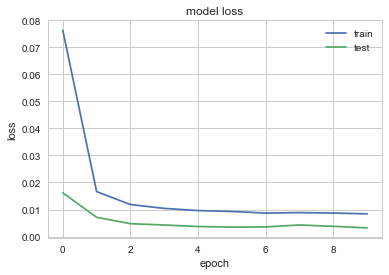

In [5]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.layers import Dropout

from keras.layers import GRU
from keras.layers import Dropout


K.clear_session()
model = Sequential()

model.add(GRU(13, input_shape=X_train.shape[1:]))
model.add(Dense(18, activation='relu'))
model.add(Dense(9, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(1)) # 1 output
model.compile(loss='mean_squared_error', optimizer='adam', lr= 0.005)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test),
          batch_size=3, verbose=0)
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Evaluate

/Users/peterjmyers/Work/keras_timeseries/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2250: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Average amount off = 0.056567745258190395
Model off = 14.15%

Baseline average prediction off = 55.79%
Better than baseline average prediction = 74.63%

Baseline yesterday prediction off = 13.82%
Better than baseline yesterday prediction = -2.40%


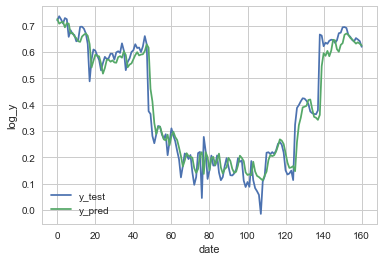

In [6]:
y_pred = model.predict(X_test)
from sklearn.metrics import mean_squared_error
from math import sqrt
y_test_mean = y_test.mean()

baseline_average = np.zeros(len(y_test))
baseline_average.fill(y_test_mean)

baseline_yesterday = np.concatenate(([y_train[-1]], y_test[:-1]))

rmse = sqrt(mean_squared_error(y_test, y_pred))
model_pct_off = rmse / y_test_mean

baseline_average_pct_off = sqrt(mean_squared_error(y_test, baseline_average)) / y_test_mean
pct_improvement_over_baseline_average = (model_pct_off/baseline_average_pct_off - 1)*-1

baseline_yesterday_pct_off = sqrt(mean_squared_error(y_test, baseline_yesterday)) / y_test_mean
pct_improvement_over_baseline_yesterday = (model_pct_off/baseline_yesterday_pct_off - 1)*-1

print("Average amount off = {}".format(rmse))
print("Model off = {:.2%}".format(model_pct_off))
print()
print("Baseline average prediction off = {:.2%}".format(baseline_average_pct_off))
print("Better than baseline average prediction = {:.2%}".format(pct_improvement_over_baseline_average))
print()
print("Baseline yesterday prediction off = {:.2%}".format(baseline_yesterday_pct_off))
print("Better than baseline yesterday prediction = {:.2%}".format(pct_improvement_over_baseline_yesterday))
plt.plot(y_test)
plt.plot(y_pred)
plt.ylabel('log_y')
plt.xlabel('date')
plt.legend(['y_test', 'y_pred'], loc='lower left')
plt.show()